# Basic Model: Ambulance + Overdose



## Ambulance Call-outs Model

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

**We assume $n_{A}=1000, p_A = 0.8$.**  
**Suppose the prior of $p_A$ is noninformative.** 
$$p(p_A) \sim Beta(1,1)$$

## Overdose Model
Now we plug in this values into the overdose model and obtain possible $O_t$ values **assuming we have $U_t$ values.**
Also, we have priors.


$$z_{t} \sim N(\mu, \sigma^{2})$$  
$$\lambda_{t}^{OD} = \exp(z_{t})$$  
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$  
$$U_t \sim Bin(O_t, p_A)$$  
For simplicity we set N =10000 for now. We need to generate reasonable $U_t$ values first. Note that $U_t$ comes from $\mu, \sigma$ following all the way through the overdose model.  



$\mu=\log0.05, \sigma=1, N=10000$.   
We suppose survey data exists: ($n_A, x_A$) known.  

**We set for our prior parameters:** $$\mu \sim U(-10,0)$$  $$\sigma \sim U(0,5)$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns

Below is the function that generate data from simulation.

In [2]:
def sim_ambulance_overdoses(mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables 
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a, size=12)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N}

In [3]:
data= sim_ambulance_overdoses()

In [4]:
data

{'o_t': array([1188,  263,   27,  309, 2121,  156,  499,  155,  583,  458,   98,
         414]),
 'u_t': array([ 960,  209,   22,  241, 1663,  130,  402,  130,  467,  357,   76,
         327]),
 'x_a': array([810, 771, 779, 808, 788, 786, 803, 784, 797, 788, 802, 808]),
 'n_a': 1000,
 'N': 10000}

In [5]:
def create_model(data):
    N = data['N']
    
    with pm.Model() as model:
        # priors 
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        # note that this prior is to be changed later
        mu_z = pm.Uniform('mu_z', -10, 0)
        sigma_z = pm.Uniform('sigma_z',0,5)
        
        # latent variables
        z_t = pm.Normal('z_t', mu=mu_z, sigma=sigma_z, shape=(12,))
        lmb_t = pm.Deterministic('lmb_t', tt.exp(z_t))
#       o_t = pm.Poisson('o_t', lmb_t*N)
        o_t = pm.Gamma('o_t', mu=lmb_t*N , sigma=tt.sqrt(lmb_t*N), shape=(12,) )
        # MCMC with discrete random variable is hard to do sampling...
        # We approximate this to Gamma dist
        
        
        #likelihood 
        pm.Poisson('u_t', o_t*p_a, observed=data['u_t'])
        pm.Binomial('x_a', n=data['n_a'], p =p_a, observed=data['x_a'])
        
    return model
        

Difference between my prior and Mike's prior exists.

In [6]:
model = create_model(data)

In [7]:
with model:
    trace = pm.sample(1000, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:11<00:00, 262.91draws/s]


In [10]:
trace['o_t'].shape

(2000, 12)

## Boxplot of $O_t$
$O_t$ is the variable of interest that we can never get data set. 
Boxplot of $O_t$ 

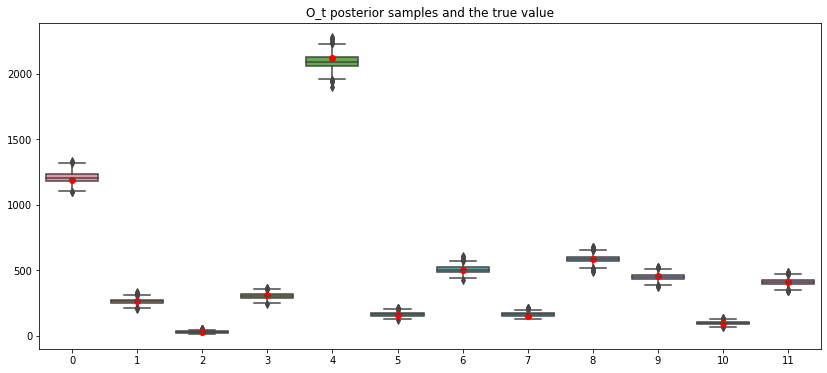

In [43]:
a4_dims = (14,6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title("O_t posterior samples and the true value")
ax=sns.boxplot(data=trace['o_t'])
ax2 = plt.plot(range(12), data['o_t'],'ro')

# Posterior Predictive Check
PPC is for likelihood. 
## PPC: $U_t$  


In [21]:
ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)

100%|██████████| 1000/1000 [00:01<00:00, 779.65it/s]


We would like to see if there is discrepency between original data set (likelihood) and the posterior predictive distribution.

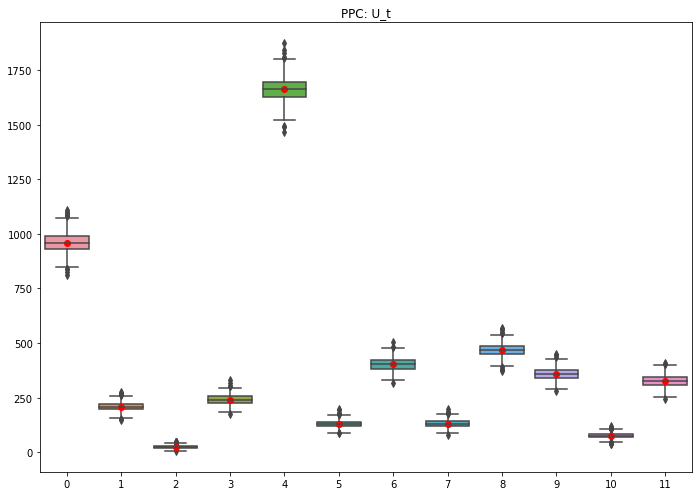

In [33]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
plt.title("PPC: U_t")
ax=sns.boxplot(data=ppc['u_t'])
ax2 = plt.plot(range(12), data['u_t'],'ro')

## PPC: $x_A$

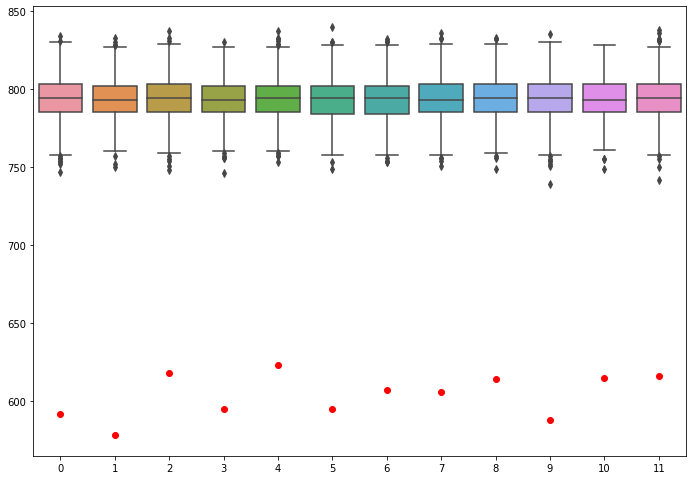

In [65]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
# plt.title("PPC: X_a")
ax=sns.boxplot(data=ppc['x_a'])
ax.set_title('PPC: X_a')
ax2 = plt.plot(range(12), data['x_a'],'ro')

The posterior predictive values are consistent with the expected value 800.
We have the most variation between the PPC and the likelihood. 

# As A Function ($P_A$(biased), N)
We want to see the effect of $P_A$: how much effect does $P_A$ has on our inference?  
bias term on $p_A$:  
Bias = $\theta -\hat{\theta} = p_A- \hat{p}_A$   
$\hat{p}_A = p_A + bias(p_A)$  

$p_A$ still be set to 0.8 but $\hat{p}_A$ will have some bias. 

$p_A$ is inferred from survey data ($n_A, x_A$). Since our estimation of the parameter is from there, we suppose that our survey data is contaminated. That is, our estimation of $p_A$ has a bias term and see how it affects the estimaton of $O_t$, our ultimate interest.

Probably the common case is underestimate the $p_A$. This can happen since drug addicts or witnesses may not want to reveal that they called aubulance for some credential concern.  

Hence, we build a function that can have bias argument so that the survey data (likelihood) may lead underestimated $p_A$ values.

In [135]:
def sim_ambulance_overdoses_bias(mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12):
    '''
    Simulate overdoses data, ambulance-call outs survey data and related variables considering 
    possible bias term for p_a
    -----------
    mu_z- float 
        log rate for lambda
    
    sigma_z -float
        variance of log lambda
    
    N - int
        Total size of population
        
    p_a - float
        probability of calling ambulance at the scene of overdose
        
    bias - float
        bias term affecting the survey data 
    
    n_a - int
        total number of survey
    
    n_T - int
        number of time points  
    '''
    # generate z_t values
    zt = np.random.normal(loc=mu_z, scale = sigma_z, size = n_T)
    
    # convert into lambda_t
    lmd_t = np.exp(zt)
    
    # generate O_t data set
    o_t = np.random.poisson(lmd_t*N)
    
    # generate U_t data set
    u_t = np.random.binomial(n=o_t, p=p_a)
    
    # generate x_t data set
    x_a = np.random.binomial(n=n_a, p=p_a+ bias, size=12)
    
    return {'o_t':o_t, 'u_t':u_t, 'x_a':x_a, 'n_a':n_a,'N':N, 'bias':bias}

So let's make a function. 

In [136]:
def test_robust(mu_z=np.log(0.05), sigma_z=1.,
                            N=10000, p_a=0.8, bias = -0.2, n_a=1000, n_T=12):
    data = sim_ambulance_overdoses_bias(mu_z=mu_z, sigma_z=sigma_z,
                            N=N, p_a=p_a, bias = bias, n_a=n_a, n_T=n_T)
    model = create_model(data)
    with model:
        trace = pm.sample(1000, chains=2)
    ppc = pm.sample_posterior_predictive(trace, samples=1000, model=model)
    
    return {'data':data, 'model':model, 'trace':trace, 'ppc':ppc}

In [127]:
my_list_unbiased = test_robust(bias = 0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 814.13it/s]


In [130]:
my_list_under = test_robust()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 799.56it/s]


In [138]:
my_list_over = test_robust(bias = +0.1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [o_t, z_t, sigma_z, mu_z, p_a]
100%|██████████| 1000/1000 [00:01<00:00, 595.47it/s]


I may need aother function to see the boxplots of ppc and posterior distrubiton on interest.

In [142]:
def visualization(mylist= my_list, post= False, u_t = False, x_a = False):
    
    if post is True: 
        # Boxplot for O_t, the variable of interest
        a4_dims = (13,6)
        fig, ax = plt.subplots(figsize=a4_dims)
        ax=sns.boxplot(data=my_list['trace']['o_t'])
        ax.set_title("O_t: posterior values")
        ax = plt.plot(range(12), mylist['data']['o_t'],'ro')
    
    
    if u_t is True:
        # boxplot of ppc : u_t
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        ax.set_title("ppc : u_t")
        ax=sns.boxplot(data=mylist['ppc']['u_t'])
        ax= plt.plot(range(12), mylist['data']['u_t'],'ro')
    
    if x_a is True: 
        # boxplot of ppc : x_a
        a4_dims = (11.7, 8.27)
        fig, ax = plt.subplots(figsize=a4_dims)
        # plt.title("PPC: X_a")
        ax=sns.boxplot(data=my_list['ppc']['x_a'])
        ax.set_title('PPC: X_a')
        ax2 = plt.plot(range(12), my_list['data']['x_a'],'ro')

Comparing $O_t$:  
bias -2 vs unbiased vs bias +1

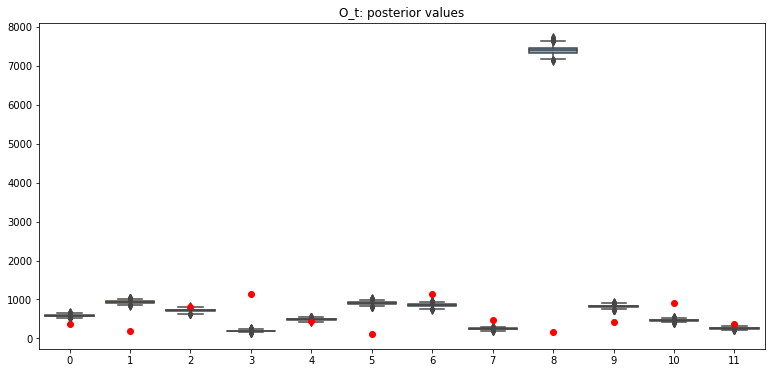

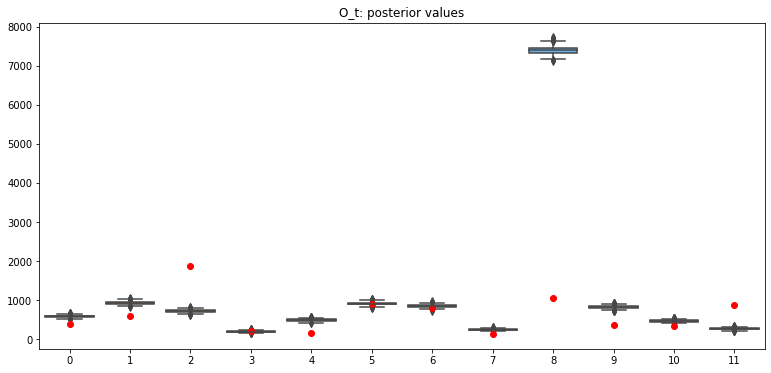

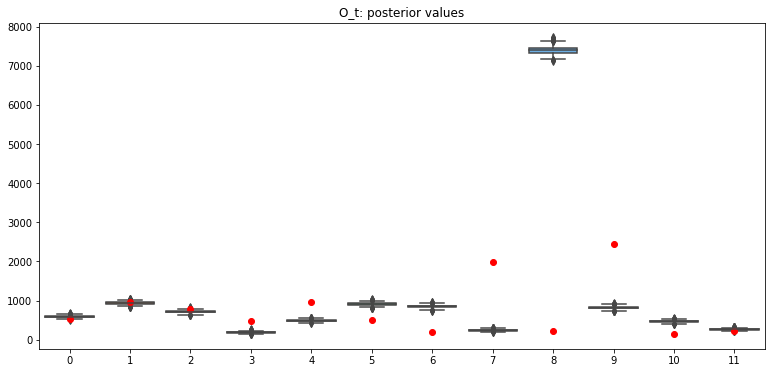

In [143]:
visualization(my_list_unbiased, post= True)
visualization(my_list_under,post= True)
visualization(my_list_over,post= True)

**I need to set the seed for random likelihood...  
ALSO maybe I should make another function to compare the three cases...**

Comparing $U_t$  
bias -2 vs unbiased vs bias +1

Comparing $x_A$  
bias -2 vs unbiased vs bias +1

### Interactive plot?

### Make a object rather than just a function ? 